# Анализ убытков мобильного приложения Pro

**Описание проекта**  
Несколько последних месяцев мобильное приложение постоянно несет убытки, несмотря на то что на привлечение пользователей был выделен большой бюджет. Необходимо узнать, что послужило причиной. Для работы есть данные: лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.  
Задача: изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

## Загрузка данных и подготовка их к анализу

**Описание данных**   
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):  

- User Id — уникальный идентификатор пользователя  
- Device — категория устройства пользователя  
- Session start — дата и время начала сессии  
- Session End — дата и время окончания сессии  
- Channel — идентификатор рекламного источника, из которого пришел пользователь  
- Region - страна пользователя  

Таблица orders_log_short (информация о заказах):  

- User Id — уникальный id пользователя, который сделал заказ  
- Event Dt — дата и время покупки  
- Revenue — выручка  

Таблица costs_short (информация о затратах на маркетинг):

- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
visits, orders, costs = (
    pd.read_csv('F:\infoshort.csv'),  # журнал сессий
    pd.read_csv('F:\orders_info_short.csv'),  # покупки
    pd.read_csv('F:\costs_info_short.csv'),  # траты на рекламу
)

Посмотрим общую информацию о таблицах

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
# Приведём данные столбцов к типу datetime
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [7]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]

In [8]:
visits.columns, orders.columns, costs.columns = (
    visits.columns.str.lower(),  
    orders.columns.str.lower(),  
    costs.columns.str.lower(), 
)

In [9]:
display(visits.head())
display(orders.head())
costs.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


## Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция для создания пользовательских профилей

In [10]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'session_end': 'last', 
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .rename(columns={'session_end': 'last_ts'})
        .reset_index()
    )


    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
   
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
  
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

### Функция для расчёта удержания

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта конверсии

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта LTV и ROI

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

### Функция для сглаживания фрейма

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Проведем исследовательский анализ данных

In [18]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,last_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,2019-05-09 08:40:06,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,2019-07-10 23:00:37,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,2019-10-03 10:44:34,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,2019-08-22 21:52:45,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,2019-10-02 00:20:52,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [19]:
# минимальная дата привлечения клиентов
print('Минимальная дата привлечения:', profiles['dt'].min())

Минимальная дата привлечения: 2019-05-01


In [20]:
# максимальная дата привлечения клиентов
print('Максимальная дата привлечения:', profiles['dt'].max()) 

Максимальная дата привлечения: 2019-10-27


In [21]:
# Посомтрим из каких стран приходят посетители и какие страны дают больше всего платящих пользователей
# Доля платящих клиентов

report = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
report.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
report.sort_values(by='Пользователи', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


Всех больше платящих клиентов приходит из США

In [22]:
# Посмотрим какими устройствами они пользуются и с каких устройств чаще всего заходят платящие пользователи

report = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
report.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
report.sort_values(by='Пользователи', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%
Mac,30042,1912,6.36%


Всех больше пользователей пользователей приходит с iPhone

In [23]:
# Посмотрим по каким рекламным каналам шло привлечение пользователей и 
# какие каналы приносят больше всего платящих пользователей
report = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
report.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
report.sort_values(by='Пользователи', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
channel,,,
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%
WahooNetBanner,8553,453,5.30%
RocketSuperAds,4448,352,7.91%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%


Больше всего платящих пользователей приходят через канал FaceBoom и TipTop

**Промежуточный вывод:**
- Минимальная дата привлечения 2019-05-01  
- Максимальная дата привлечения: 2019-10-27   
- Всех больше платящих клиентов приходит из США   
- Всех больше платящих клиентов пользуются iPhone   
- Больше всего платящих пользователей приходят через канал FaceBoom и TipTop  

## Маркетинг

In [24]:
# Узнаем сколько денег потратили всего
display('Потрачено денег всего {:.0f} долларов.'.format(costs['costs'].sum()))

'Потрачено денег всего 105497 долларов.'

In [25]:
# Сколько денег потратили на каждый источник
report_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
report_costs = report_costs.rename(columns = {'costs': 'Расходы на компанию'}, level = 0)
report_costs.index = report_costs.index.rename('Канал привлечения')
report_costs

,Расходы на компанию
Канал привлечения,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Половину из этих денег потратили на Tip Top, ещё треть на FaceBoom.

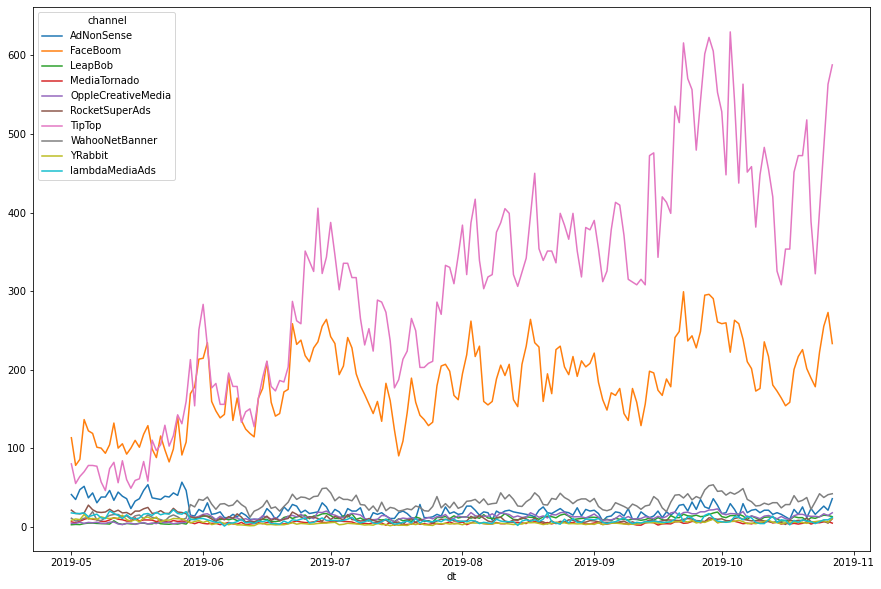

In [26]:
# Сколько денег потратили по времени

df=costs.pivot_table(index = 'dt', columns = 'channel', values = 'costs', aggfunc = 'sum')
df.plot(figsize=(15, 10));

In [27]:
# Узнаем сколько в среднем стоило привлечение одного пользователя из каждого источника.
# Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.
# Используем профили пользователей.

print('CAC на одного пользователя {:.2f} доллара.'.format(profiles['acquisition_cost'].mean()))

profiles_channel = profiles.query('channel!="organic"')
report_channel = profiles_channel.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost',
                                                                                            ascending=False)
report_channel = report_channel.rename(columns = {'acquisition_cost': 'CAC, стоимость одного пользователя'}, level = 0)
report_channel.index=report_channel.index.rename('Канал привлечения')
report_channel

CAC на одного пользователя 0.70 доллара.


,"CAC, стоимость одного пользователя"
Канал привлечения,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


В среднем стоимость привлечения клиентов самая высокая у Tip Top - 2.79 доллара, далее идут FaceBoom – 1,11 доллара, AdNonSense – 1 доллар.

**Промежуточный вывод:**
- Потрачено денег всего 105497 долларов
- Половину из этих денег потратили на Tip Top, ещё треть на FaceBoom
- в среднем стоимость привлечение одного пользователя 0,7 даллара. В разбивке по источникам трафика средняя стоимость привлечения клиентов самая высокая у Tip Top - 2.79 доллара, далее идут FaceBoom – 1,11 доллара, AdNonSense – 1 доллар. 


## Оцените окупаемость рекламы для привлечения пользователей

Установим момент и горизонт анализа данных. Предположим, что на календаре 1 ноября 2019 года, и зададим 2 недели горизонт анализа.

In [28]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

### Проанализируем общую окупаемость рекламы

Оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

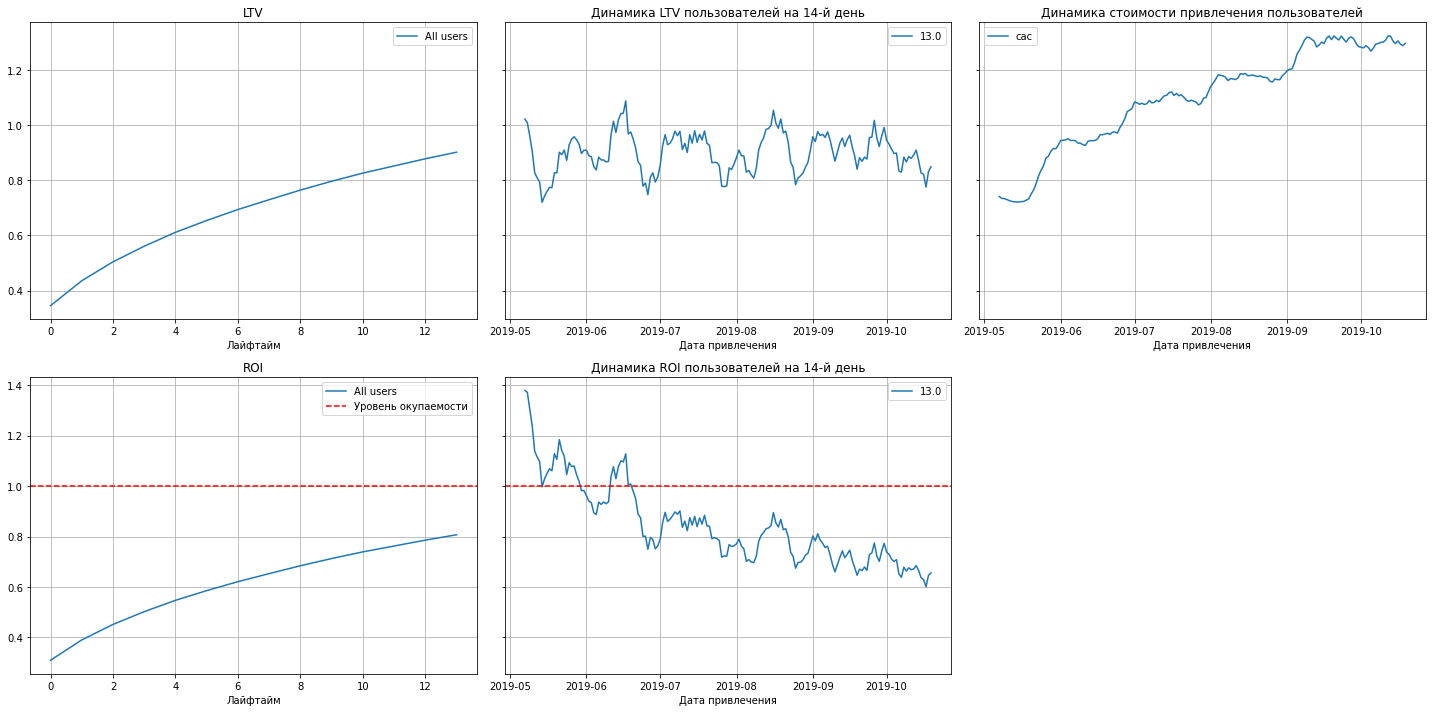

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_channel, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**По графикам можно сделать такие выводы:**  
Реклама не окупается. ROI в конце второй недели так и не достигла порога окупаемости.  
CAC не стабилен. Можно предположить, что дело в нерациональном увеличении рекламного бюджета.
Динамика ROI снижается, начиная с 1го месяца ниже уровня окупаемости  и не растет. А рекламный бюджет продолжали увеличивать.
На LTV влияет сезонный фактор, но этот показатель достаточно стабилен.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

Начнём с разбивки по устройствам: передадим параметру dimensions столбец device.

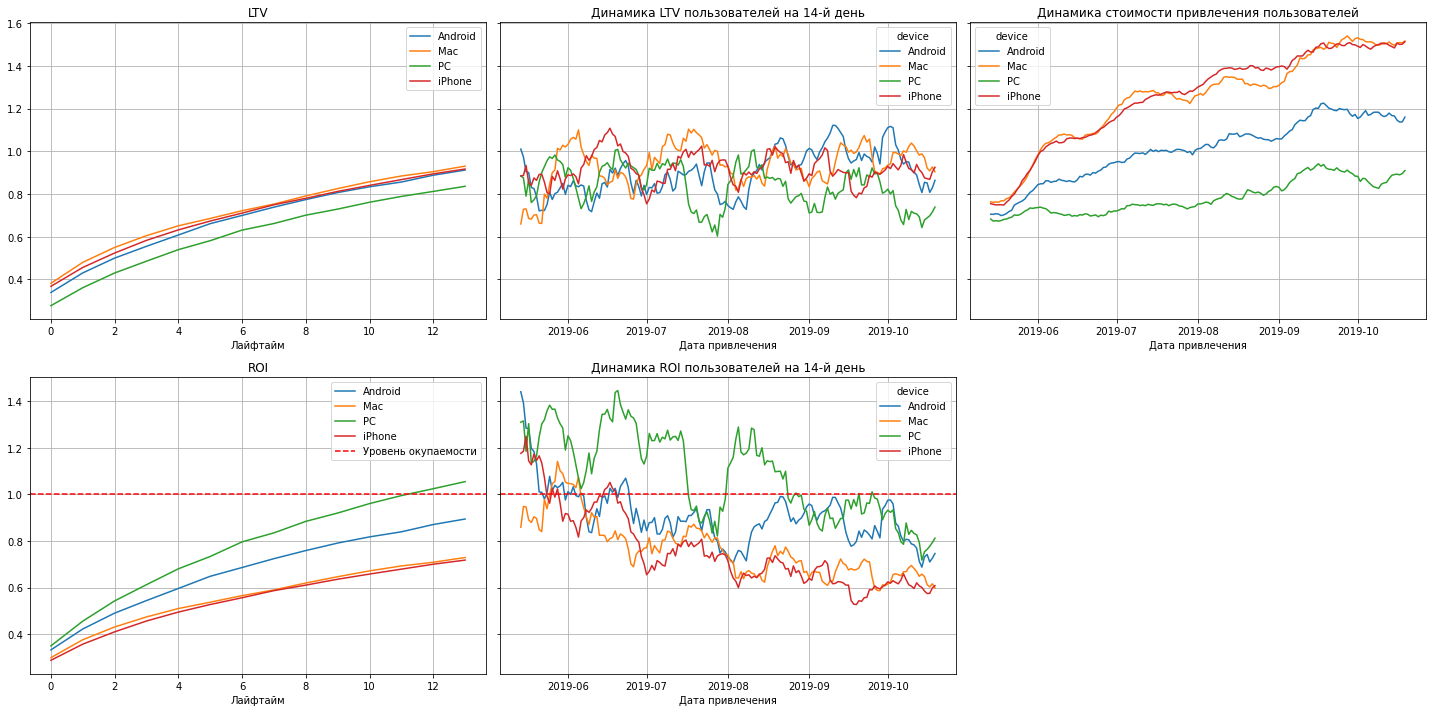

In [30]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_channel, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- MAC, iPhone и Android не окупаются. На них же самые большие вложения.  
- У PC самые низкие вложения и при этом выходит на окупаемость, хоть и при регрессирующей динамике всё же.  
- Возможно, пользователи MAC, iPhone и Android сталкиваются с какой-то проблемой при использовании приложения.  
- Так же, возможно, версия приложения для PC самая удобная.  

### Проанализируем окупаемость рекламы с разбивкой по странам

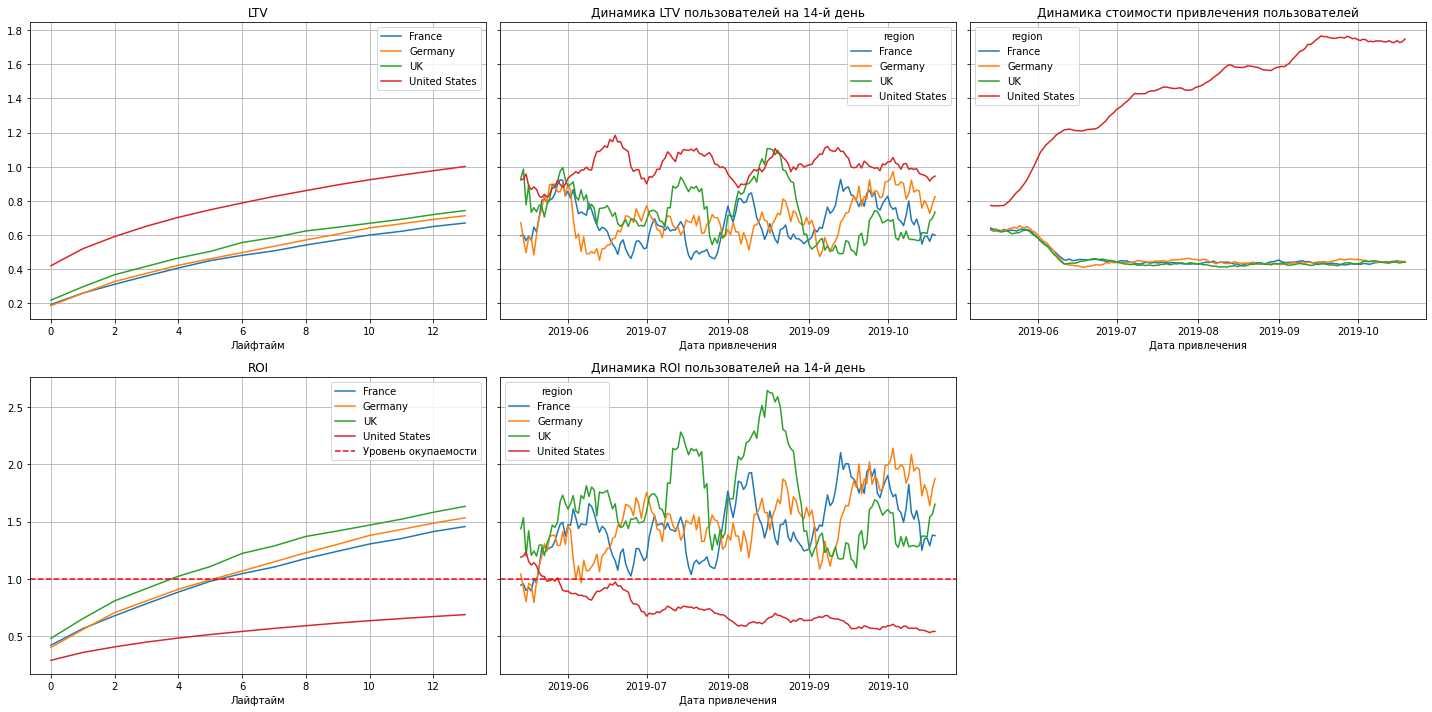

In [31]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_channel, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Самая плохая картинка у US. У них самые большие вливания в привлечения клиентов, но они не окупаются. У Европейских стран стабильный бюджет и стабильная динамика продаж. При этом у US продажи всех выше, обороты большие, а толку нет.
Возможно, для US выбрана неверная стратегия.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

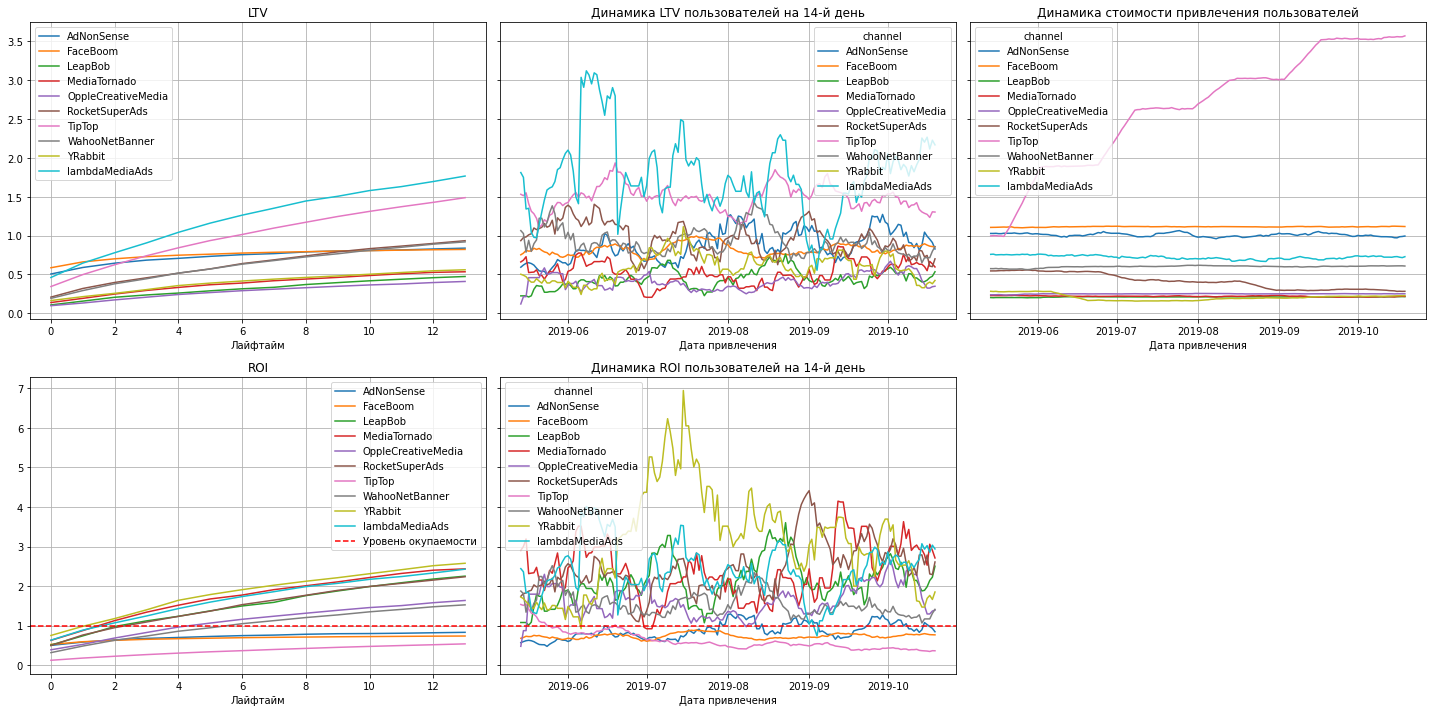

In [32]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_channel, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Каналы привлечения Tip-Top, Face Boom, AdNonSense не окупаются. Продажи по каналам Tip-Top высокие, но только за счет больших вливаний, чем у других. У Face Boom и AdNonSense вливания стабильны.
Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.


**Узнаем, в чём причина: в низкой конверсии или низком удержании.**

Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().

**Посмотрим конверсию и удержание с разбивкой по каналам привлечения.**

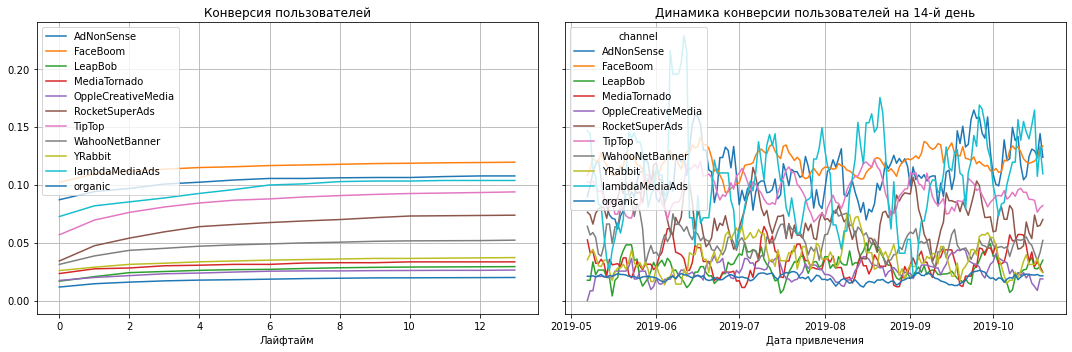

In [33]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия выглядит вполне стабильной, посмотрим на удержание. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

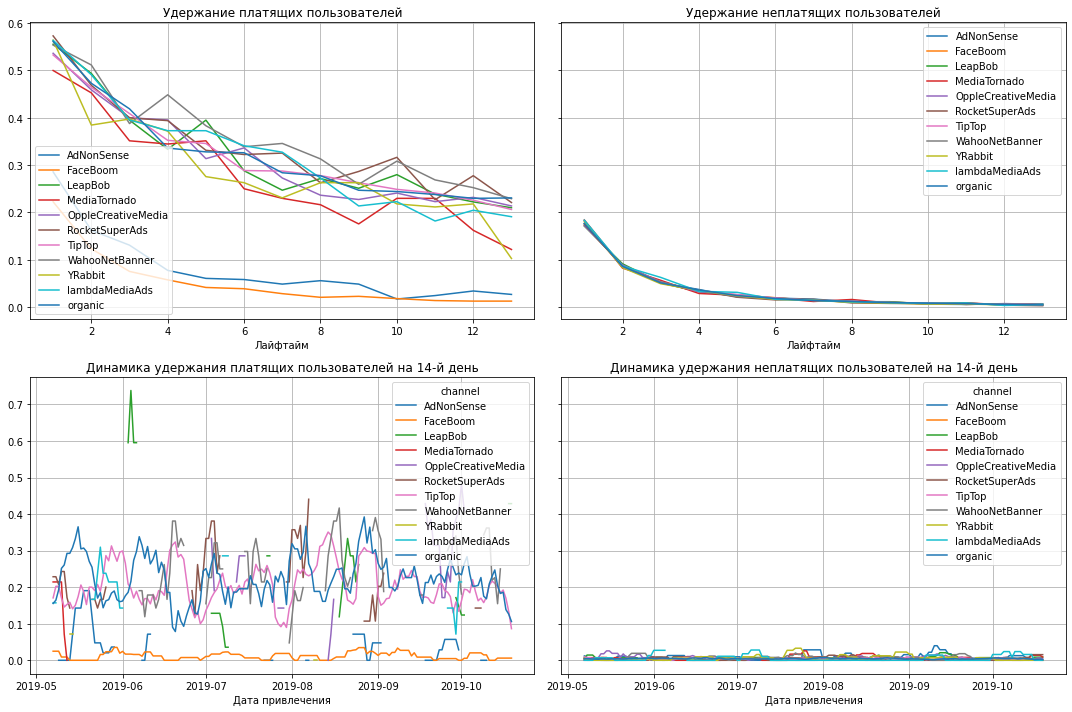

In [34]:
# смотрим удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В разбивке по рекламным каналам удержание платящих пользователей каналов AdNonSense и FaceBoom примерно такое же как удержание неплатящих пользователей.
Значит, качество платящих пользователей из этих каналов очень низкое.

**Посмотрим конверсию и удержание с разбивкой по странам.**

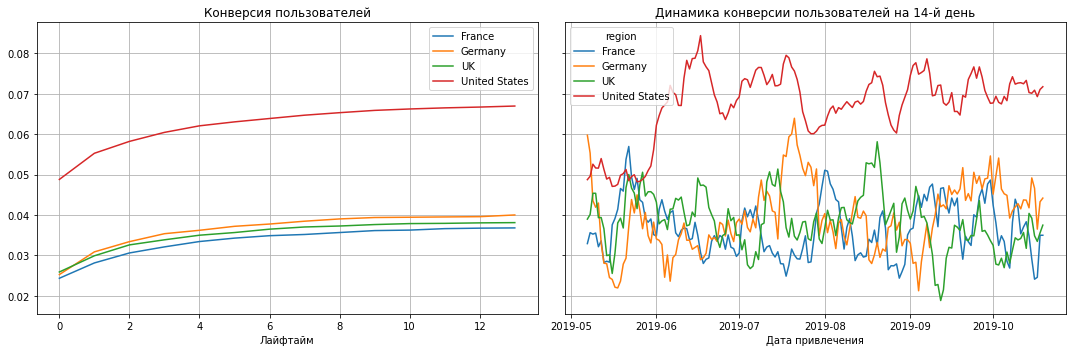

In [35]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

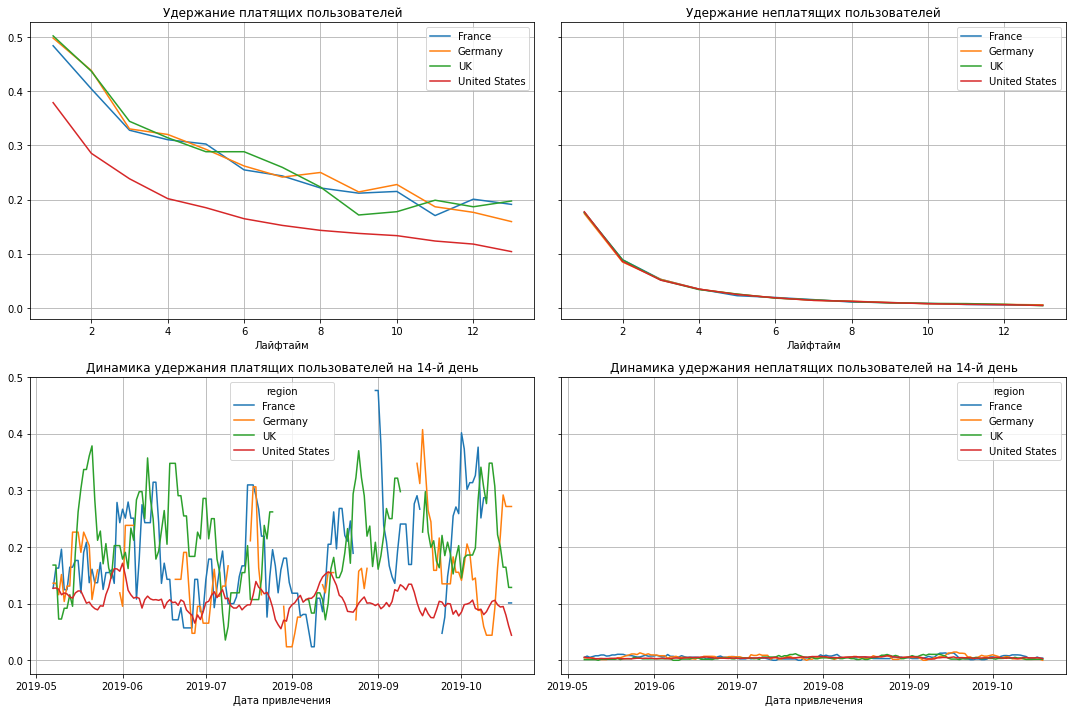

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия  в US всех выше, а удержание всех ниже. Высокую конверсию можно объяснить более высокими вложениями в привлечение клиентов и более высокие значения прибыли, т.е. объемы больше, но не эффективны.

**Посмотрим конверсию и удержание с разбивкой по устройствам.**

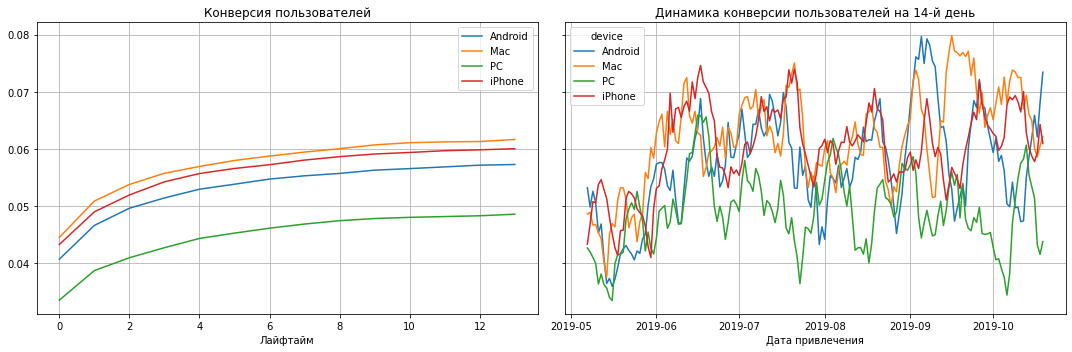

In [37]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

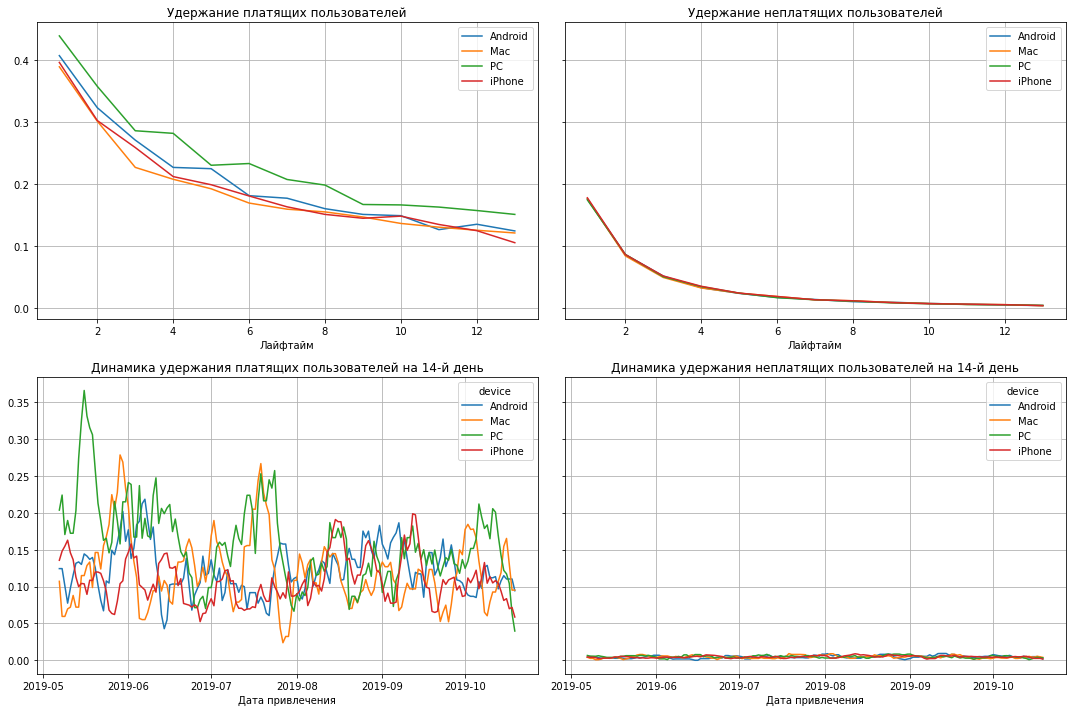

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Явных лидеров или аутсайдеров по конверсии или удержании нет. Удержание так же имеет динамику снижения. 

## Выводы

- Всех больше платящих клиентов приходит из США
- Всех больше платящих клиентов пользуются iPhone
- Больше всего платящих пользователей приходят через канал FaceBoom и TipTop
- Половина расходов на привлечение клиентов потрачена так же на канал Tip Top, а ещё треть на FaceBoom
- В среднем стоимость привлечения клиентов самая высокая у Tip Top - 2.79 доллара, далее идут FaceBoom – 1,11 доллара, AdNonSense – 1 доллар
- Проанализировав общую рекламную окупаемость можно сделать вывод о нерациональном увеличении рекламного бюджета. Динамика окупаемости начиная с 1го месяца ниже уровня окупаемости и не растет. А рекламный бюджет продолжали при этом увеличивать.
- MAC, iPhone и Android не окупаются. На них же самые большие вложения. У PC самые низкие вложения и при этом выходит на окупаемость, хоть и при регрессирующей динамике всё же. Возможно, пользователи MAC, iPhone и Android сталкиваются с какой-то проблемой при использовании приложения. Так же, возможно, версия приложения для PC самая удобная.
- У US  самые большие вливания в привлечения клиентов, но они не окупаются. У Европейских стран стабильный бюджет и стабильная динамика продаж. При этом у США продажи всех выше, обороты большие, а положительного результата нет.
- Каналы привлечения Tip-Top, Face Boom, AdNonSense не окупаются. Продажи по каналам Tip-Top высокие, но только за счет больших вливаний, чем у других. У Face Boom и AdNonSense вливания стабильны. Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.
- Канал lambdaMediaAds показывает свою эффективность по конверсии и удержании, на данный канал стоит обратить внимание.
- Так же в США в июне начали увеличивать бюджет на привлечение пользователей и прибыль от пользователей iPhone в июне имеет резкий рост. Далее в июле прибыль от пользователей iPhone падает. Тогда к августу снова вливают деньги в США и прибыль от пользователей iPhone снова растет. В середине сентября заметный провал по прибыли в приложении у пользователей iPhone. Возможно новых вливаний не было. Так как пользователей из США всех большей, платящие клиенты всех больше пользуются iPhone стоит обратить внимание на удобство приложения на этой платформе.  
- В результате данного исследования можно сказать, что удержание платящих пользователей каналов AdNonSense и FaceBoom примерно такое же как удержание неплатящих пользователей. Значит, качество платящих пользователей из этих каналов очень низкое. Удержание платящих пользователей с каналов очень низкое при высоком уровне затрат. Нужно скорректировать рекламный бюджет.
